In [1]:
# Uncomment if needed
#!pip install numpy
#!pip install pillow
#!pip install torch
#!pip install torchvision

In [2]:
# To import necessary libraries
import numpy as np  # Library for numerical computations, especially with arrays
import torch  # Main PyTorch library for tensor operations
import torch.nn as nn  # Submodule of PyTorch for building neural network layers and structures
import torch.nn.functional as F  # Functional interface for various neural network operations (like activation functions)
import torch.optim as optim  # Submodule for optimization algorithms (e.g., SGD, Adam)
import torchvision  # Library that provides tools for image datasets and transformations
import torchvision.transforms as transforms  # Module for applying transformations to image datasets
import matplotlib.pyplot as plt  # Library for plotting and visualizing data
import urllib.request  # Module for opening and reading URLs
from PIL import Image  # Python Imaging Library for opening, manipulating, and saving image files


In [3]:
# To create a series of transformations to be applied to images
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # To convert the image to a PyTorch tensor (scales pixel values to [0, 1])
        # To normalize the tensor to have a mean of 0.5 and standard deviation of 0.5 for each color channel (RGB)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


In [4]:
# To load the CIFAR-10 dataset for training
train_data = torchvision.datasets.CIFAR10(
    root='./data',  # To specify the directory where the dataset will be stored
    train=True,     # To indicate that this is the training dataset
    download=True,  # To download the dataset if it is not already available in the specified directory
    transform=transform  # To apply the defined transformations (e.g., ToTensor, Normalize) to the images
)

# To load the CIFAR-10 dataset for testing
test_data = torchvision.datasets.CIFAR10(
    root='./data',  # To specify the directory for the dataset
    train=False,    # To indicate that this is the testing dataset
    download=True,  # To download the dataset if it is not already available
    transform=transform  # To apply the same transformations to the test images
)

# To create a DataLoader for the training dataset to facilitate batch processing
train_loader = torch.utils.data.DataLoader(
    train_data,      # The dataset to load
    batch_size=32,   # To specify the number of samples per batch
    shuffle=True,    # To shuffle the data at every epoch to ensure randomness
    num_workers=2    # To use 2 subprocesses for data loading to improve efficiency
)

# To create a DataLoader for the testing dataset
test_loader = torch.utils.data.DataLoader(
    test_data,       # The dataset to load
    batch_size=32,   # To specify the number of samples per batch
    shuffle=True,    # To shuffle the data to ensure randomness during testing
    num_workers=2    # To use 2 subprocesses for data loading
)


100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# To retrieve the first image and its corresponding label from the training dataset
image, label = train_data[0]  # 'train_data' is the CIFAR-10 dataset; this fetches the first item (image-label pair)

# To get the size of the retrieved image tensor
image.size()  # This will return the dimensions of the image tensor (e.g., [channels, height, width])


torch.Size([3, 32, 32])

In [6]:
# To define a list of class names corresponding to the labels in the CIFAR-10 dataset
class_names = [
    'plane',  # Class 0: airplane
    'car',    # Class 1: automobile
    'bird',   # Class 2: bird
    'cat',    # Class 3: cat
    'deer',   # Class 4: deer
    'dog',    # Class 5: dog
    'frog',   # Class 6: frog
    'horse',  # Class 7: horse
    'ship',   # Class 8: ship
    'truck'   # Class 9: truck
]

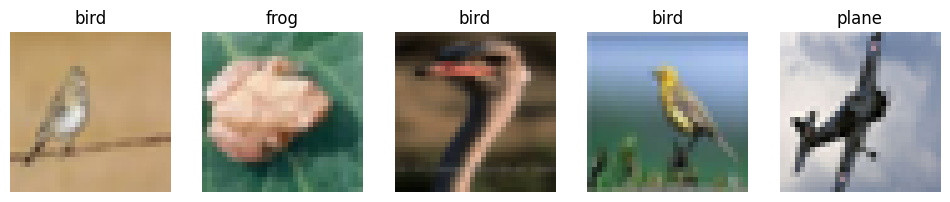

In [7]:
# Function to display a set of images with their corresponding labels
def show_images(images, labels):
    # To create a figure with subplots; one for each image
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))  # 1 row, 'len(images)' columns

    # To iterate through images, labels, and axes for plotting
    for img, label, ax in zip(images, labels, axes):
        # To convert the image tensor to a NumPy array, transpose dimensions, and undo normalization for display
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)) * 0.5 + 0.5)
        # To set the title of each subplot to the corresponding class name
        ax.set_title(class_names[label])
        # To turn off the axis for better visual presentation
        ax.axis("off")

    # To show the figure with the images
    plt.show()

# To get an iterator for the training data loader
data_iter = iter(train_loader)

# To retrieve a batch of images and their corresponding labels from the training data
images, labels = next(data_iter)

# To display the first 5 images and their labels in the batch using the show_images function
show_images(images[:5], labels[:5])


In [8]:
# To define a neural network class that inherits from nn.Module
class NeuralNet(nn.Module):

    def __init__(self):
        # To initialize the parent class
        super().__init__()

        # First convolutional layer: takes 3 input channels (RGB), outputs 12 channels, with a 5x5 kernel
        self.conv1 = nn.Conv2d(3, 12, 5)

        # Max pooling layer: reduces the spatial dimensions by a factor of 2 (2x2 pooling)
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer: takes 12 input channels, outputs 24 channels, with a 5x5 kernel
        self.conv2 = nn.Conv2d(12, 24, 5)

        # To define fully connected layers:
        # First fully connected layer: flattens the output of the last convolutional layer
        # 24 channels, each 5x5 spatial dimensions, results in 24 * 5 * 5 = 600 inputs to this layer
        self.fc1 = nn.Linear(24 * 5 * 5, 120)

        # Second fully connected layer: takes 120 inputs and outputs 96
        self.fc2 = nn.Linear(120, 98)

        # Third fully connected layer: takes 96 inputs and outputs 10 (number of classes in CIFAR-10)
        self.fc3 = nn.Linear(98, 10)

    # To define the forward pass through the network
    def forward(self, x):
        # Apply the first convolutional layer, followed by ReLU activation, and then max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # To apply the second convolutional layer, followed by ReLU activation, and then max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # To flatten the tensor to feed into the fully connected layers (batch size remains)
        x = torch.flatten(x, 1)  # To flatten all dimensions except batch

        # To apply the first fully connected layer, followed by ReLU activation
        x = F.relu(self.fc1(x))

        # To apply the second fully connected layer, followed by ReLU activation
        x = F.relu(self.fc2(x))

        # To apply the third fully connected layer (final output layer)
        x = self.fc3(x)

        # To return the output of the network (logits for each class)
        return x

In [9]:
# To instantiate the neural network model
net = NeuralNet()  # To create an instance of the NeuralNet class defined earlier

# To define the loss function for multi-class classification
loss_function = nn.CrossEntropyLoss()
# This loss function combines softmax and negative log-likelihood loss, suitable for classification tasks

# To set up the optimizer for updating the model's weights
optimizer = optim.SGD(
    net.parameters(),  # To pass the parameters of the neural network to the optimizer
    lr=0.001,         # Learning rate: controls how much to adjust the weights during optimization
    momentum=0.9      # Momentum: helps accelerate gradients vectors in the right directions, improving convergence speed
)


In [10]:
# To train the neural network for a specified number of epochs
for epoch in range(40):  # To loop over the dataset multiple times (32 epochs)
    print(f'Training epoch {epoch}...')  # To print the current epoch number
    running_loss = 0.0  # To initialize the total loss for this epoch

    # To iterate over the training data loader
    for i, data in enumerate(train_loader):
        inputs, labels = data  # To get the inputs (images) and labels (targets) from the current batch

        optimizer.zero_grad()  # Zero the gradients of the model parameters to prevent accumulation
        outputs = net(inputs)  # Forward pass: compute predicted outputs by passing inputs through the network

        loss = loss_function(outputs, labels)  # To compute the loss by comparing outputs to the true labels
        loss.backward()  # Backward pass: compute gradients of the loss with respect to model parameters
        optimizer.step()  # To update model parameters using the computed gradients

        running_loss += loss.item()  # To accumulate the loss for the current batch

    # To print the average loss for the epoch (total loss divided by number of batches)
    print(f'Loss: {running_loss/len(train_loader):.5f}')


Training epoch 0...
Loss: 2.22947
Training epoch 1...
Loss: 1.77593
Training epoch 2...
Loss: 1.51207
Training epoch 3...
Loss: 1.38509
Training epoch 4...
Loss: 1.28635
Training epoch 5...
Loss: 1.20962
Training epoch 6...
Loss: 1.14193
Training epoch 7...
Loss: 1.07888
Training epoch 8...
Loss: 1.03233
Training epoch 9...
Loss: 0.98530
Training epoch 10...
Loss: 0.94475
Training epoch 11...
Loss: 0.90618
Training epoch 12...
Loss: 0.86676
Training epoch 13...
Loss: 0.83527
Training epoch 14...
Loss: 0.80164
Training epoch 15...
Loss: 0.77282
Training epoch 16...
Loss: 0.74045
Training epoch 17...
Loss: 0.71573
Training epoch 18...
Loss: 0.66435
Training epoch 20...
Loss: 0.63468
Training epoch 21...
Loss: 0.61173
Training epoch 22...
Loss: 0.58985
Training epoch 23...
Loss: 0.56355
Training epoch 24...
Loss: 0.53768
Training epoch 25...
Loss: 0.52102
Training epoch 26...
Loss: 0.49632
Training epoch 27...
Loss: 0.47413
Training epoch 28...
Loss: 0.45441
Training epoch 29...
Loss: 0.4

In [11]:
# To save the trained model's state dictionary (weights and biases)
torch.save(net.state_dict(), 'trained_net.pth')
# 'net.state_dict()' retrieves the model parameters (weights and biases) for all layers
# 'trained_net.pth' is the filename where the model parameters will be saved
# This file can be used later to load the model for inference or further training

In [12]:
# To instantiate a new instance of the NeuralNet model
net = NeuralNet()

# To load the previously saved model parameters (weights and biases) into the neural network
net.load_state_dict(torch.load('trained_net.pth'))
# 'torch.load()' reads the saved state dictionary from the specified file ('trained_net.pth')
# 'load_state_dict()' updates the model with the loaded parameters, allowing the model to be used for inference or further training


<ipython-input-12-dd3aafea2970>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('trained_net.pth'))


<All keys matched successfully>

In [13]:
# To initialize counters for correct predictions and total number of samples
correct = 0
total = 0

# To set the model to evaluation mode (disables dropout and batch normalization)
net.eval()

# To disable gradient computation for inference to reduce memory consumption and improve speed
with torch.no_grad():
    # To iterate over the test data loader
    for data in test_loader:
        images, labels = data  # To get the images and corresponding labels from the test batch

        # Forward pass: compute predicted outputs by passing images through the network
        outputs = net(images)

        # To get the predicted class by finding the index of the maximum log-probability
        _, predicted = torch.max(outputs, 1)

        # To update the total count of samples processed
        total += labels.size(0)

        # To count the number of correct predictions by comparing predicted and true labels
        correct += (predicted == labels).sum().item()

# To calculate the accuracy as the percentage of correctly predicted samples
accuracy = 100 * correct / total

# To print the accuracy of the model on the test dataset
print(f'Accuracy: {accuracy}%')


Accuracy: 66.86%


In [14]:
# To define URLs for images to be predicted
url1 = "https://images.pexels.com/photos/1170986/pexels-photo-1170986.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"  # URL for a cat image
url2 = "https://images.pexels.com/photos/46148/aircraft-jet-landing-cloud-46148.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"  # URL for a plane image
url3 = "https://images.pexels.com/photos/825947/pexels-photo-825947.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"  # URL for a dog image

# To define a transform to preprocess the images before passing them to the model
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # To resize the image to 32x32 pixels to match the input size of the model
    transforms.ToTensor(),          # To convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # To normalize the image with mean and std deviation
])

def load_img(image_url):
    # To set up a request with a user-agent header to avoid blocking
    req = urllib.request.Request(image_url, headers={'User-Agent': 'Mozilla/5.0'})
    with urllib.request.urlopen(req) as url_response:  # To open the URL and retrieve the image
        image = Image.open(url_response)  # To open the image from the URL response
        image = new_transform(image)  # To apply the defined transformations to the image
        image = image.unsqueeze(0)  # To add a batch dimension (1, 3, 32, 32) for the model input
    return image  # To aeturn the preprocessed image

# To create a list of image URLs to be predicted
image_paths = [url1, url2, url3]  # To add URLs as needed
images = [load_img(img) for img in image_paths]  # To load and preprocess each image URL

# To set the model to evaluation mode (disables dropout and batch normalization)
net.eval()
with torch.no_grad():  # To disable gradient computation for inference
    # To iterate through the preprocessed images
    for image in images:
        output = net(image)  # Forward pass: get the model's output for the image
        _, predicted = torch.max(output, 1)  # To get the predicted class index with the highest score
        # To print the predicted class name based on the predicted index
        print(f"Prediction: {class_names[predicted.item()]}")

Prediction: truck
Prediction: plane
Prediction: dog
